In [1]:
from tqdm.notebook import tqdm, trange
import pandas as pd
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
import seaborn as sns
import pyqtgraph as pg
import pyqtgraph.opengl as gl

from calibrators import Calibrator
from calibrators.models import Complex
from calibrators.models.gradients.learn import SqDec

In [2]:
data = {
    'good': pd.read_csv('./data_archive/good_readings.csv'),
    'okay': pd.read_csv('./data_archive/okay_readings.csv'),
    'bad': pd.read_csv('./data_archive/bad_readings.csv'),
    'ref': pd.Series([17.8480, 4.5939, 50.8366], index=['mag_x','mag_y','mag_z'])
}

In [9]:
data_adj = {}
coefs = {}
calibs = {}
for key, val in data.items():
    if key == 'ref': continue
    calibs[key] = Calibrator(
        val.values, data['ref'],
        Model=Complex, model_params={'gradient_params':{'Learn':SqDec}},
        verbose=True
    )
    data_adj[key] = calibs[key].calibrate(100000)
    coefs[key] = calibs[key].coefs

In [10]:
coefs['good']

,bias,skew_x,skew_y,skew_z
x,24.306417,-0.348529,-1.179266,-0.197840
y,7.321260,-0.903732,0.421054,-0.541377
z,18.775190,-0.771904,0.076954,1.008962


In [11]:
coefs['okay']

,bias,skew_x,skew_y,skew_z
x,26.485626,-0.262437,-1.178982,0.141435
y,6.164262,-1.024556,0.185350,-0.514477
z,19.961081,-0.656122,0.299980,1.079361


In [12]:
coefs['bad']

,bias,skew_x,skew_y,skew_z
x,27.980804,-0.136953,0.172923,-1.034979
y,27.487492,0.609533,0.593507,0.155147
z,37.622875,-0.794270,0.455894,0.186969


In [13]:
print('good:', np.sqrt((data_adj['good']**2).sum(axis=1)).mean())
print('okay:', np.sqrt((data_adj['okay']**2).sum(axis=1)).mean())
print('bad:', np.sqrt((data_adj['bad']**2).sum(axis=1)).mean())
print('ref:', np.sqrt((data['ref']**2).sum()))

good: 53.979183
okay: 54.079353
bad: 53.98736
ref: 54.07416130436051


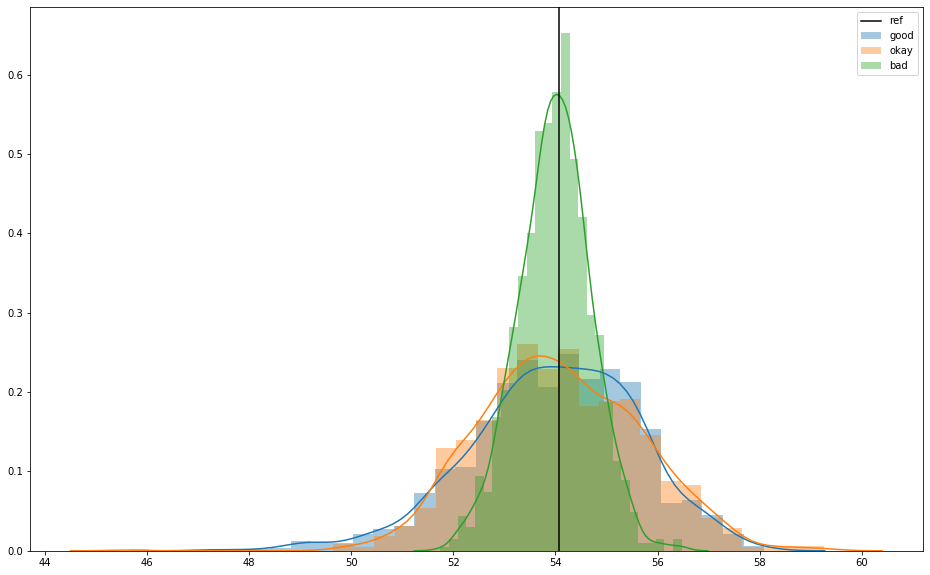

In [14]:
plt.figure(figsize=(16,10))
sns.distplot(np.sqrt((data_adj['good']**2).sum(axis=1)), label='good')
sns.distplot(np.sqrt((data_adj['okay']**2).sum(axis=1)), label='okay')
sns.distplot(np.sqrt((data_adj['bad']**2).sum(axis=1)), label='bad')
plt.axvline(np.sqrt((data['ref']**2).sum()), color='#000000', label='ref')
plt.legend()